# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Общая информация

In [1]:
pip install tabulate

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from lightgbm import LGBMRegressor
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

In [4]:
#открываю датафрейм
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
#общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
#смотрю первые строки
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
#количество пропусков
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
#явные дубликаты
df.duplicated().sum()

4

### Предобработка данных

In [9]:
#удаление дубликатов
df = df.drop_duplicates()
df.duplicated().sum()

0

#### NumberOfPictures

В таблице бросается в глаза столбец с нулевыми значениями, я его проверю первым

In [10]:
df['NumberOfPictures'].isna().sum()

0

In [11]:
df['NumberOfPictures'].value_counts()

0    354365
Name: NumberOfPictures, dtype: int64

In [12]:
#Удаляю столбец
df = df.drop('NumberOfPictures', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  PostalCode         354365 non-null  int64 
 14  LastSeen           354365 non-null  object
dtypes: int64(6), object(9)
memory usage: 43.3+ MB


#### Price

Проверяю важный столбец с целевым признаком

In [13]:
df['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64

In [14]:
df['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

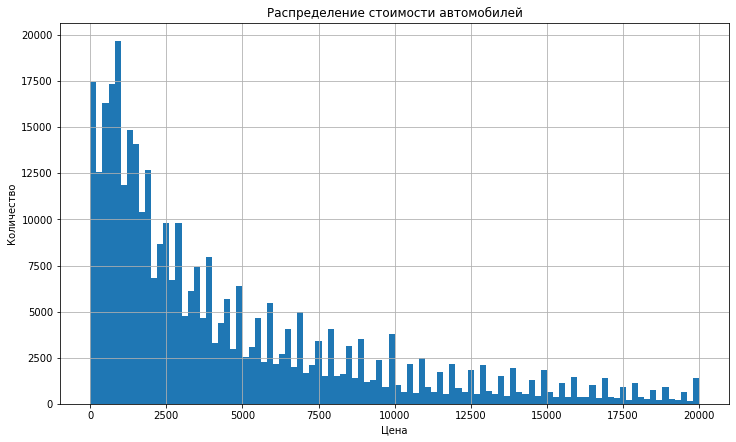

In [ ]:
#посмотрю значения на графике
df['Price'].hist(bins=100,figsize=(12,7))
plt.title('Распределение стоимости автомобилей')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

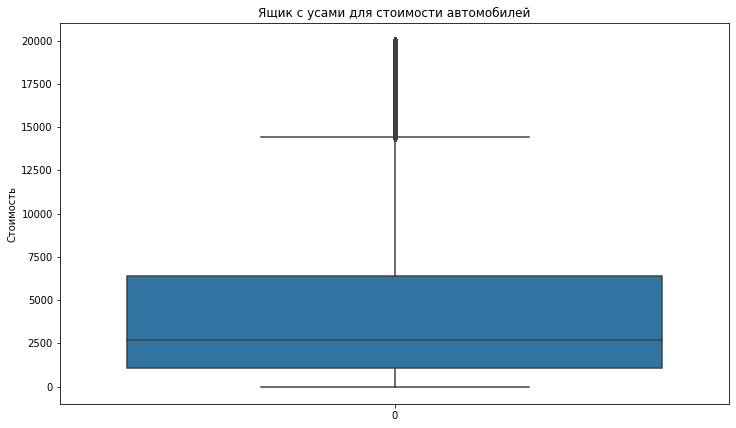

In [ ]:
#построю ящик с усами
plt.figure(figsize=(12,7))
sns.boxplot(data=df['Price'])
plt.title('Ящик с усами для стоимости автомобилей')
plt.ylabel('Стоимость')
plt.show()

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Да, верно графики выбрала, их можно совместить, чтобы было удобнее:)</div>

При просмотре статистик по данному столбцу, видно смещение данных. Судя по графикам, аномальные значения находятся в районе 0 и в районе 15 000. Что бы понять какие именно значения удалять, надо посмотреть квантилии

In [ ]:
df['Price'].quantile([.05, 0.95])

0.05      200.0
0.95    14600.0
Name: Price, dtype: float64

In [ ]:
df = df.query('0 != Price <= 14600')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325941 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        325941 non-null  object
 1   Price              325941 non-null  int64 
 2   VehicleType        292742 non-null  object
 3   RegistrationYear   325941 non-null  int64 
 4   Gearbox            308849 non-null  object
 5   Power              325941 non-null  int64 
 6   Model              308983 non-null  object
 7   Kilometer          325941 non-null  int64 
 8   RegistrationMonth  325941 non-null  int64 
 9   FuelType           297007 non-null  object
 10  Brand              325941 non-null  object
 11  Repaired           261303 non-null  object
 12  DateCreated        325941 non-null  object
 13  PostalCode         325941 non-null  int64 
 14  LastSeen           325941 non-null  object
dtypes: int64(6), object(9)
memory usage: 39.8+ MB


#### RegistrationYear

Смотрю столбец с датой регистрации автомобиля.

In [ ]:
df['RegistrationYear'].value_counts()

2000    23020
1999    21946
2005    21142
2001    19551
2003    19334
        ...  
1949        1
2222        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 137, dtype: int64

Вижу много явно аномальных значений. Для того что бы понять какие именно года считать аномалии, построю ящик с усами и посмотрю квантилии

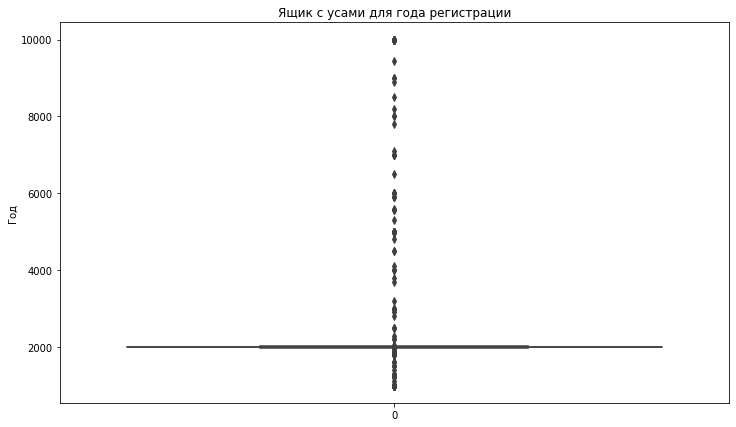

In [ ]:
#построю ящик с усами
plt.figure(figsize=(12,7))
sns.boxplot(data=df['RegistrationYear'])
plt.title('Ящик с усами для года регистрации')
plt.ylabel('Год')
plt.show()

In [ ]:
df['RegistrationYear'].quantile([.05, 0.95])

0.05    1993.0
0.95    2016.0
Name: RegistrationYear, dtype: float64

- В столбце RegistrationYear помимо аномально высоких значений, имеются аномально низкие. Я не знаю как точно определить дату, раньше которой начинаются эти аномалии, Но учитывая, что сервис новый и он не о продаже ретро автомобилей, и нам не хочется удалять много данных, то предлагаю оставить авто младше 1970 года, а все что меньше удалить
- так же оставляю только те авто , дата регистрации которых не позднее даты последней активности пользователя

In [ ]:
df['LastSeen'].max()

'2016-04-07 14:58:51'

In [ ]:
df = df.query('1970 < RegistrationYear < 2017')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311234 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        311234 non-null  object
 1   Price              311234 non-null  int64 
 2   VehicleType        291798 non-null  object
 3   RegistrationYear   311234 non-null  int64 
 4   Gearbox            296224 non-null  object
 5   Power              311234 non-null  int64 
 6   Model              296480 non-null  object
 7   Kilometer          311234 non-null  int64 
 8   RegistrationMonth  311234 non-null  int64 
 9   FuelType           287815 non-null  object
 10  Brand              311234 non-null  object
 11  Repaired           252949 non-null  object
 12  DateCreated        311234 non-null  object
 13  PostalCode         311234 non-null  int64 
 14  LastSeen           311234 non-null  object
dtypes: int64(6), object(9)
memory usage: 38.0+ MB


Проверяю столбец RegistrationMonth

In [ ]:
df['RegistrationMonth'].describe()

count    311234.000000
mean          5.802242
std           3.690431
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

Вижу минимальное значение ноль. Этого не может быть что бы месяц был нулевым. Что бы не терять много данных заменю нули медианой

In [ ]:
df['RegistrationMonth'] = np.where((df.RegistrationMonth == 0), 6, df.RegistrationMonth)
df['RegistrationMonth'].unique()

array([ 6,  8,  7, 10, 12, 11,  2,  1,  4,  5,  9,  3])

#### Power

In [ ]:
df['Power'].value_counts()

0        31884
75       22088
60       14738
150      13163
101      12390
         ...  
1199         1
1200         1
1968         1
16311        1
341          1
Name: Power, Length: 648, dtype: int64

In [ ]:
df['Power'].describe()

count    311234.000000
mean        108.296937
std         184.025769
min           0.000000
25%          69.000000
50%         102.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

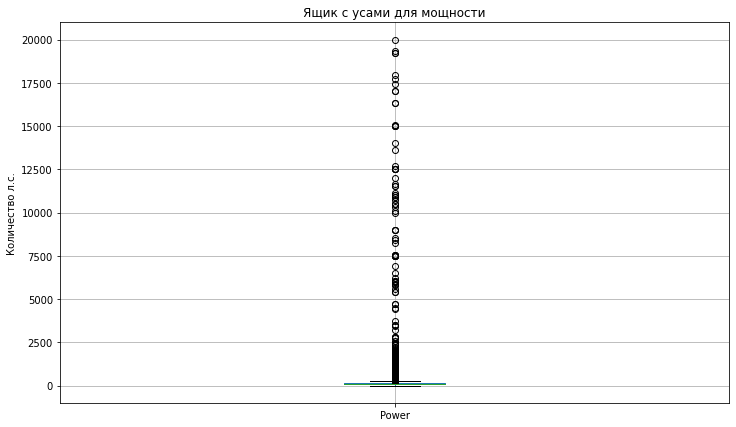

In [ ]:
#построю ящик с усами
df.boxplot('Power', figsize=(12,7))
plt.title('Ящик с усами для мощности')
plt.ylabel('Количество л.с.')
plt.show()


Уточнила в Яндексе, что мощность авто может быть и 5000 л.с., и пусть это какие-то эксклюзивные машины и их мало, но они имеют право быть. Удаляю аномалии равные нулю и больше 5000

In [ ]:
#удаляю аномальные значения
df = df.query('0 != Power < 5000')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279282 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        279282 non-null  object
 1   Price              279282 non-null  int64 
 2   VehicleType        268433 non-null  object
 3   RegistrationYear   279282 non-null  int64 
 4   Gearbox            274017 non-null  object
 5   Power              279282 non-null  int64 
 6   Model              268689 non-null  object
 7   Kilometer          279282 non-null  int64 
 8   RegistrationMonth  279282 non-null  int64 
 9   FuelType           264015 non-null  object
 10  Brand              279282 non-null  object
 11  Repaired           237346 non-null  object
 12  DateCreated        279282 non-null  object
 13  PostalCode         279282 non-null  int64 
 14  LastSeen           279282 non-null  object
dtypes: int64(6), object(9)
memory usage: 34.1+ MB


#### Gearbox

Смотрю пропуски в столбце с типом коробки передач. Данные значения я удалю, так как на цену существенно влияет этот признак, а восстановить данные или поставить заглушку будет некорректно

In [ ]:
df['Gearbox'].value_counts()

manual    222759
auto       51258
Name: Gearbox, dtype: int64

In [ ]:
df['Gearbox'].isna().sum()

5265

In [ ]:
#удаляю пропущенные значения
df = df.dropna(subset=['Gearbox'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274017 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        274017 non-null  object
 1   Price              274017 non-null  int64 
 2   VehicleType        264404 non-null  object
 3   RegistrationYear   274017 non-null  int64 
 4   Gearbox            274017 non-null  object
 5   Power              274017 non-null  int64 
 6   Model              264083 non-null  object
 7   Kilometer          274017 non-null  int64 
 8   RegistrationMonth  274017 non-null  int64 
 9   FuelType           259983 non-null  object
 10  Brand              274017 non-null  object
 11  Repaired           234475 non-null  object
 12  DateCreated        274017 non-null  object
 13  PostalCode         274017 non-null  int64 
 14  LastSeen           274017 non-null  object
dtypes: int64(6), object(9)
memory usage: 33.4+ MB


#### Model

В столбце с моделью автомобиля видны пропущенные значения. Проверю уникальные значения этого столбца и удалю пропуски.Так как цена явно зависит от модели автомобиля, то для получения реальных результатов заменить пропуски на другие значения будет не корректно

In [ ]:
df['Model'].unique()

array(['grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'twingo', 'a_klasse', 'scirocco', '5er', 'arosa',
       'other', 'civic', 'transporter', 'punto', 'e_klasse', 'clio',
       'kadett', 'one', 'fortwo', '1er', 'b_klasse', nan, 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', 'astra', '156',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a1', 'focus', 'a4',
       'tt', 'a6', 'jazz', 'omega', 'polo', 'slk', '7er', 'combo',
       'corsa', '80', '147', 'z_reihe', 'sorento', 'ibiza', 'eos',
       'touran', 'getz', 'insignia', 'ka', 'almera', 'megane', 'a3',
       'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', '6_reihe', 'c4', 'panda', 'up',
       'i_reihe', 'ceed', 'kangoo', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', 'modus', 'fox', 'matiz', 'beetle', 'rio', 'logan',
       'spider', 'cuore', 's_max', 'a2', 'c3', '1_reihe', 'sharan',
       'avensis', '

In [ ]:
df['Model'] = df['Model'].fillna('unknown')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274017 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        274017 non-null  object
 1   Price              274017 non-null  int64 
 2   VehicleType        264404 non-null  object
 3   RegistrationYear   274017 non-null  int64 
 4   Gearbox            274017 non-null  object
 5   Power              274017 non-null  int64 
 6   Model              274017 non-null  object
 7   Kilometer          274017 non-null  int64 
 8   RegistrationMonth  274017 non-null  int64 
 9   FuelType           259983 non-null  object
 10  Brand              274017 non-null  object
 11  Repaired           234475 non-null  object
 12  DateCreated        274017 non-null  object
 13  PostalCode         274017 non-null  int64 
 14  LastSeen           274017 non-null  object
dtypes: int64(6), object(9)
memory usage: 33.4+ MB


#### VehicleType

Видны пропуски в колонке с кузовом авто. Это важные данные для определения цены автомобиля, но так как из таблицы уже было удалено большое количество данных, пропуски в этом столбце я заполню заглушкой 'unknow'

In [ ]:
df['VehicleType'].isna().sum()

9613

In [ ]:
df['VehicleType']=df['VehicleType'].fillna('unknow')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274017 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        274017 non-null  object
 1   Price              274017 non-null  int64 
 2   VehicleType        274017 non-null  object
 3   RegistrationYear   274017 non-null  int64 
 4   Gearbox            274017 non-null  object
 5   Power              274017 non-null  int64 
 6   Model              274017 non-null  object
 7   Kilometer          274017 non-null  int64 
 8   RegistrationMonth  274017 non-null  int64 
 9   FuelType           259983 non-null  object
 10  Brand              274017 non-null  object
 11  Repaired           234475 non-null  object
 12  DateCreated        274017 non-null  object
 13  PostalCode         274017 non-null  int64 
 14  LastSeen           274017 non-null  object
dtypes: int64(6), object(9)
memory usage: 33.4+ MB


#### FuelType

От типа топлива тоже может зависеть цена на авто, но удалять лишние данные я не буду, а заполню значением 'other'

In [ ]:
df['FuelType'].value_counts()

petrol      176694
gasoline     77988
lpg           4524
cng            476
hybrid         154
other           83
electric        64
Name: FuelType, dtype: int64

In [ ]:
df['FuelType']=df['FuelType'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274017 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        274017 non-null  object
 1   Price              274017 non-null  int64 
 2   VehicleType        274017 non-null  object
 3   RegistrationYear   274017 non-null  int64 
 4   Gearbox            274017 non-null  object
 5   Power              274017 non-null  int64 
 6   Model              274017 non-null  object
 7   Kilometer          274017 non-null  int64 
 8   RegistrationMonth  274017 non-null  int64 
 9   FuelType           274017 non-null  object
 10  Brand              274017 non-null  object
 11  Repaired           234475 non-null  object
 12  DateCreated        274017 non-null  object
 13  PostalCode         274017 non-null  int64 
 14  LastSeen           274017 non-null  object
dtypes: int64(6), object(9)
memory usage: 33.4+ MB


#### Repaired

Проверю столбец с указанием ремонта автомобиля. И вместо пропусков поставлю заглушку

In [ ]:
df['Repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [ ]:
df['Repaired'].isna().sum()

39542

In [ ]:
df['Repaired']=df['Repaired'].fillna('unknow')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274017 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        274017 non-null  object
 1   Price              274017 non-null  int64 
 2   VehicleType        274017 non-null  object
 3   RegistrationYear   274017 non-null  int64 
 4   Gearbox            274017 non-null  object
 5   Power              274017 non-null  int64 
 6   Model              274017 non-null  object
 7   Kilometer          274017 non-null  int64 
 8   RegistrationMonth  274017 non-null  int64 
 9   FuelType           274017 non-null  object
 10  Brand              274017 non-null  object
 11  Repaired           274017 non-null  object
 12  DateCreated        274017 non-null  object
 13  PostalCode         274017 non-null  int64 
 14  LastSeen           274017 non-null  object
dtypes: int64(6), object(9)
memory usage: 33.4+ MB


#### Графики

In [ ]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,67112,2016-04-05 18:18:39
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknow,2016-04-04 00:00:00,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,6,other,volkswagen,unknow,2016-03-17 00:00:00,27472,2016-03-31 17:17:06
10,2016-03-26 19:54:18,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,2016-03-26 00:00:00,96224,2016-04-06 10:45:34
11,2016-04-07 10:06:22,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes,2016-04-07 00:00:00,57290,2016-04-07 10:25:17
12,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,unknow,2016-03-15 00:00:00,37269,2016-04-01 13:16:16


In [ ]:
#удаление признаков не влияющих на дальнейшую работу
df = df.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274017 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             274017 non-null  int64 
 1   VehicleType       274017 non-null  object
 2   RegistrationYear  274017 non-null  int64 
 3   Gearbox           274017 non-null  object
 4   Power             274017 non-null  int64 
 5   Model             274017 non-null  object
 6   Kilometer         274017 non-null  int64 
 7   FuelType          274017 non-null  object
 8   Brand             274017 non-null  object
 9   Repaired          274017 non-null  object
 10  PostalCode        274017 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 25.1+ MB


<Figure size 800x640 with 0 Axes>

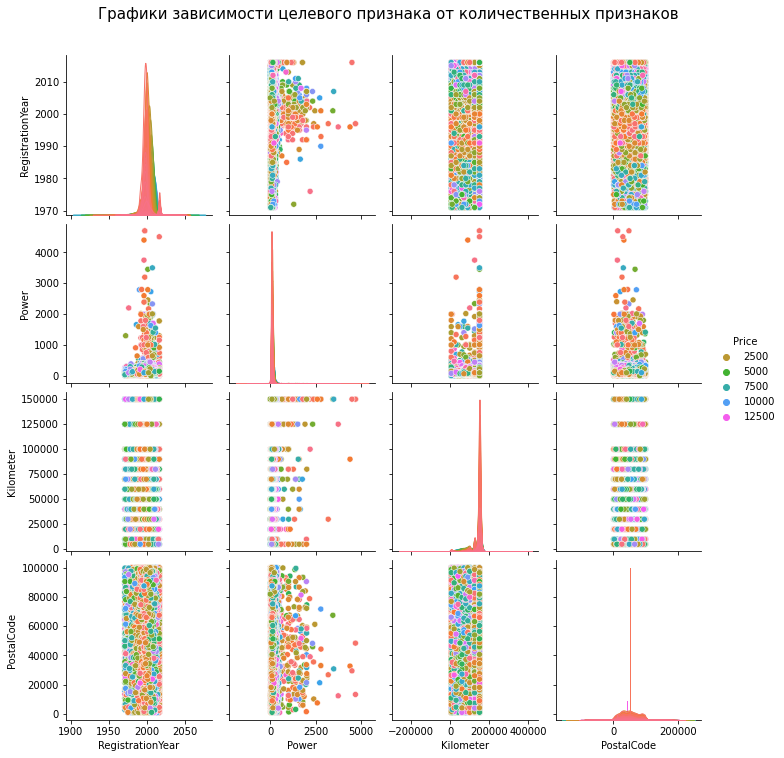

In [ ]:
#строю график зависимости
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(df, kind="scatter", hue="Price", palette = "husl")
plt.suptitle("Графики зависимости целевого признака от количественных признаков", y=1.05, fontsize=15)
plt.show()

По графику видно, что зависимость есть

[Text(0.5, 1.0, 'Распределение признака Power'),
 Text(0.5, 0, 'Значение признака'),
 Text(0, 0.5, 'Power')]

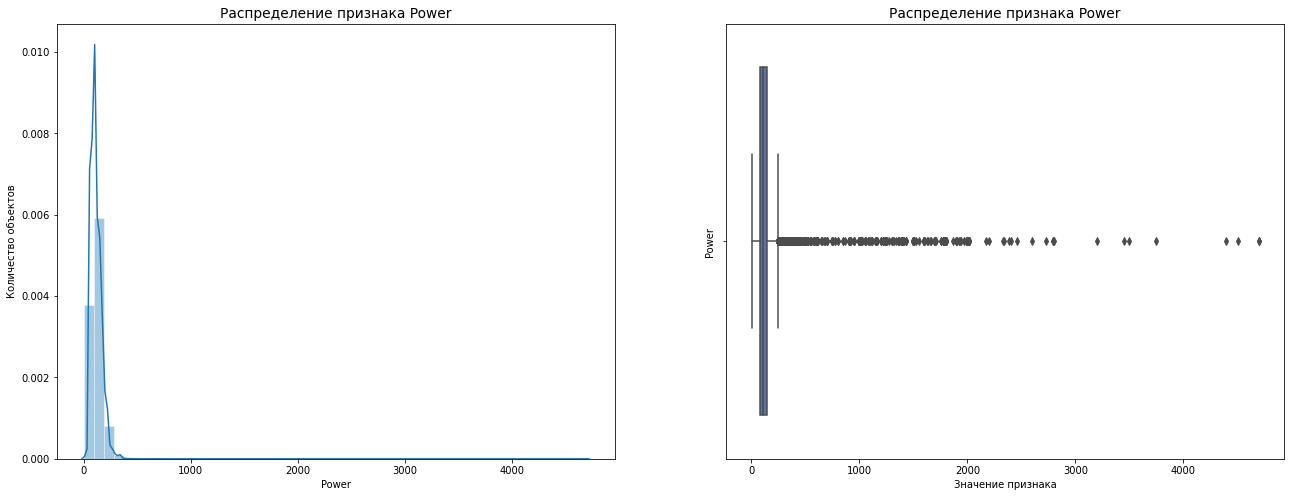

In [ ]:
df.reset_index(inplace=True)

fig, axs = plt.subplots(ncols=2,figsize=(22, 8))
sns.set(font_scale=1.15)

gr1 = sns.distplot(df["Power"], kde=True, ax=axs[0])
gr2 = sns.boxplot(df["Power"], orient='h', ax=axs[1])

gr1.set(title=f'Распределение признака {"Power"}', xlabel=f'{"Power"}', ylabel='Количество объектов')
gr2.set(title=f'Распределение признака {"Power"}', xlabel='Значение признака', ylabel=f'{"Power"}')

### Выводы

В данном разделе были изучены данные и произведена их подготовка:
- обнаружены и удалены дубликаты
- удалены нулевые значения из целевого признака
- изучены и удалены аномальные значения в столбцах
- в категориальных признаках поставлена заглушка вместо пропусков, для сохранения данных
- удалены стобцы, не влияющие на дальнейшее исследование


## Обучение моделей

### Разделение на выборки и кодирование

In [ ]:
features = df.drop(['Price'], axis=1)
target = df['Price']

features.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)


In [ ]:
numeric = ['RegistrationYear', 'Power','Kilometer','PostalCode']
categorical = ['VehicleType', 'Gearbox','Model','FuelType', 'Brand', 'Repaired']

col_transformer = ColumnTransformer(
                            transformers=[
                                ('scaler', StandardScaler(), numeric),
                                ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical)],)

X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

### DecisionTreeRegressor

In [ ]:
def metrics(model):
    results = model.cv_results_
    best_index = model.best_index_

    fit_time = results['mean_fit_time'][best_index]
    score_time = results['mean_score_time'][best_index]
    RMSE = abs(model.best_score_)

    print(f"Fit time: {fit_time:.5f}, Predict time: {score_time:.5f}, Best RMSE: {RMSE:.5f}")

In [ ]:
model_tree = DecisionTreeRegressor(random_state=42)
parameters = {'max_depth':range(12, 20),
              'min_samples_split': range(2, 4),
              'min_samples_leaf': range(1, 3)}

gs_tree = GridSearchCV(model_tree, parameters, cv=3, scoring='neg_root_mean_squared_error', n_jobs = -1)
gs_tree.fit(X_train, y_train)

best_tree_params = gs_tree.best_params_

print('Лучшие параметры:',best_tree_params)
metrics(gs_tree)

Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}
Fit time: 5.08981, Predict time: 0.06828, Best RMSE: 1557.28781


### RandomForestRegressor

In [ ]:
model_forest = RandomForestRegressor(random_state=42)
parameter = {'max_depth':range(10, 100, 30),
              'n_estimators': range(2,10,2)}

gs_forest = GridSearchCV(model_forest, parameter, cv=3, scoring='neg_root_mean_squared_error', n_jobs = -1)
gs_forest.fit(X_train, y_train)

best_forest_params = gs_forest.best_params_

print('Лучшие параметры:',best_forest_params)
metrics(gs_forest)

Лучшие параметры: {'max_depth': 40, 'n_estimators': 8}
Fit time: 28.85402, Predict time: 0.37197, Best RMSE: 1394.99563


### LightGBM

In [ ]:
model_lgbm = LGBMRegressor(random_state=42)
param = {'num_leaves':[30, 50, 100, 1000], 'learning_rate':[.1, .3, .5]}

gs = GridSearchCV(model_lgbm, param, cv=3, scoring='neg_root_mean_squared_error', n_jobs = -1)
gs.fit(X_train, y_train)

best_lgbm_params = gs.best_params_

print('Лучшие параметры:',best_lgbm_params)
metrics(gs)

Лучшие параметры: {'learning_rate': 0.1, 'num_leaves': 1000}
Fit time: 74.45752, Predict time: 3.01468, Best RMSE: 1290.54325


### Выводы

- Данные были разделены и закодированы.
Были рассмотрены модели:
- DecisionTreeRegressor(Качество модели: 1557.28781, Время обучения: 5.36905, Время предсказания: 0.05326)
- RandomForestRegressor(Качество модели: 1394.99563, Время обучения: 29.09109, Время предсказания: 0.34697)
- LGBMRegressor(Качество модели: 1290.54325, Время обучения: 74.45752, Время предсказания: 3.01468)

## Анализ моделей

Для наглядности я создам таблицу, в которой будет отображено качество модели, время обучения и время предсказания для каждой модели

In [ ]:
data = [["DecisionTreeRegressor", 1557.28781, 5.36905, 0.05326],
        ["RandomForestRegressor", 1394.99563, 29.09109, 0.34697],
        ["LGBMRegressor", 1290.54325, 74.45752, 3.01468]]

col_names = ["Модель", "Качество модели", "Время обучения", "Время предсказания"]

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════════════╤═══════════════════╤══════════════════╤══════════════════════╕
│ Модель                │   Качество модели │   Время обучения │   Время предсказания │
╞═══════════════════════╪═══════════════════╪══════════════════╪══════════════════════╡
│ DecisionTreeRegressor │           1557.29 │          5.36905 │              0.05326 │
├───────────────────────┼───────────────────┼──────────────────┼──────────────────────┤
│ RandomForestRegressor │           1395    │         29.0911  │              0.34697 │
├───────────────────────┼───────────────────┼──────────────────┼──────────────────────┤
│ LGBMRegressor         │           1290.54 │         74.4575  │              3.01468 │
╘═══════════════════════╧═══════════════════╧══════════════════╧══════════════════════╛


Так как в данном проекте, важно не только качество модели, но и время на обучение и предсказание, то я буду отталкиваться от максимально допустимого качества >2500. Все модели подходят по параметру качества, но быстрее всего это делает DecisionTreeRegressor. Но у самой быстрой модели качество похуже, чем у RandomForestRegressor. Я думаю что раз разница во времени не такая большая, а качество лучше, то для теста я выбираю модель случайного леса.

In [ ]:
model_f = RandomForestRegressor(max_depth = 40, n_estimators = 8, random_state=42)

model_f.fit(X_train, y_train)

model_pr = model_f.predict(X_test)

rsme_f = mean_squared_error(y_test, model_pr) ** .5

print(f"RMSE:{rsme_f:.5f}")

RMSE:1356.98507


### Выводы

Исходя из условий задания, была выбрана лучшая модель не только по качеству, но и по времени на обучение и предсказания. Лучшая модель была проверена на тестовых данных и дала хороший результат

## Выводы

- Задача была построить модель для определения стоимости автомобиля, с лушими показателями качества , скорости предсказания и врмени обучения

- В ходе работы были обнаружены и удалены дубликаты, удалены нулевые значения из целевого признака, изучены и удалены аномальные значения в столбцах,в категориальных признаках поставлена заглушка вместо пропусков, для сохранения данных, удалены стобцы, не влияющие на дальнейшее исследование

- Были рассмотрены модели: DecisionTreeRegressor, RandomForestRegressor и LGBMRegressor.

- Проанализировав показатели выбранных моделей, я пришла к выводу, что моделью с допустимым качеством и самой быстрой скоростью лбучения и предсказания, является модель DecisionTreeRegressor, но rsme RandomForestRegressor было в 2 раза ниже, это значительная разница и поэтому в качестве лучшей модели я выбрала случайный лес.  Проверка на тестовых данных дала хороший результат